# Speaker Diarization Demo
#### Simon McKnight, Imperial College London
---
#### Started: 7 July 2019  |  Last updated: 28 July 2019  |  Last opened: {{datetime.today().strftime('%d %B %Y')}}
---
Contents:
<ol>
    <li><a href="#intro">Introduction to speaker diarization</a></li>
    <li><a href="#upload">Upload audio file</a></li>
    <li><a href="#enhancement">Speech enhancement</a></li>
    <li><a href="#featExtraction">Feature extraction</a></li>
    <li><a href="#speechSegments">Segmentation</a></li>
    <li><a href="#labelling">Labelling</a></li>
    <li><a href="#runDiarTk">Clustering</a></li>
    <li><a href="#evaluate">Evaluate results</a></li>
    <li><a href="#transcript">Create transcript</a></li>
    <li><a href="#references">References</a></li>
</ol>

## Introduction to Speaker Diarization <label id="intro">

Speaker diarization involves distinguishing different speakers in any given speech signal.  It primarily revolves around two main aspects:  (i) segmentation of speech data into homogeneous segments (e.g.  speech, noise or silence); and (ii) labelling and/or clustering the speech segments attributed to individual speakers.  However, the preprocessing steps involved in extracting suitable features from the original speech signal have a big impact on the performance of speaker diarization systems.  A simple flow chart of the steps is shown below.

<img src="190709_SpeakerDiarizationFlowChart.png" width=800>

This notebook will demonstrate the use of a speaker diarization toolkit called DiarTk and [ ]

## Upload Audio File<label id="upload">

<img src="190709_AMIEdinburghLayout.png" width = 250 style="float: right; margin: 0 20px;">
<div style="text-align: justify;">The speech analysed in this demo is from an AMI corpus meeting.  It is denoted AMI_20050204-1206 when used in the NIST rich text transcription challenge, but is the same as the AMI ES2008b meeting.  That meeting involved two male and two female speakers, with omnidirectional array microphones set up in the room as shown in the diagram to the right.  The speakers also headset and lapel microphones, but they are not used in this notebook.

The speech was originally provided by NIST in SPHERE (.sph) format, so needed to be converted to wave (.wav) format before continuing.

See [<a href="#carletta">1</a>] for more information about the AMI corpus.</div>

In [1]:
path = "audio/"
array1 = "AMI_20050204-1206_ci01_NONE.wav"
array2 = "AMI_20050204-1206_ci02_NONE.wav"

In [2]:
import datetime
startTime = datetime.datetime.now()

import Audio
fs, data = Audio.getAudio(path, (array1, array2))

endTime = datetime.datetime.now()
totalTime = endTime - startTime
print("\nThis cell took {} seconds to run.".format(totalTime.seconds))

The audio file was sampled at 16,000 Hz with 35,706,539 samples overall and 16 channels.
The length of the file is 37 mins 11.66 secs.

This cell took 21 seconds to run.


In [3]:
# Check dimensions of audio 
data.shape

(35706539, 16)

Note that the data.shape tuple output shows (rows, columns).  It is standard for frame data to be stacked vertically by time, yet shown horizontally in graphs.

The AMI data samples are measured in 16 bits linearly, so they range from $\pm32,768$.  This is normalised to $\pm1$ in the analysis.

In [4]:
2**16/2

32768.0

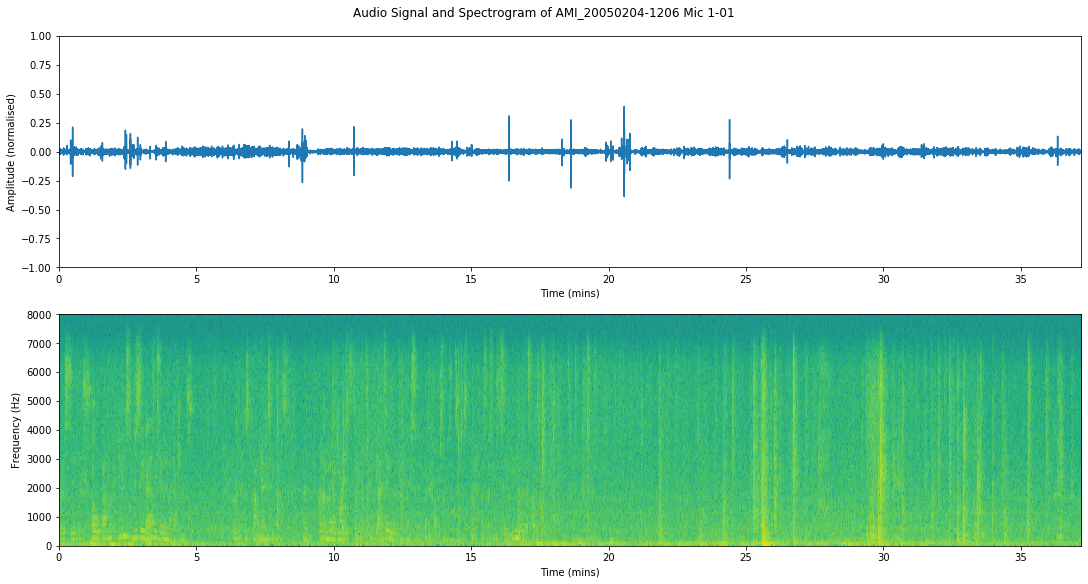

In [5]:
# Plotting audio signal and spectrogram - channel 1 only

import matplotlib.pyplot as plt
%matplotlib inline

channel = 1
t = [i/(fs*60) for i in range(len(data))]
sig = [i/32768 for i in data[:, channel]]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), constrained_layout=True)
plt.suptitle("Audio Signal and Spectrogram of AMI_20050204-1206 Mic 1-0{}".format(channel))

ax1.set_xlim([0, t[-1]])
ax1.set_xlabel("Time (mins)")
ax1.set_ylim([-1, 1])
ax1.set_ylabel("Amplitude (normalised)")

ax1.plot(t, sig)
#plt.savefig("audiosignal.svg")

ax2.specgram(sig, Fs=fs)
ax2.set_xlim([0, t[-1]])
ax2.set_xlabel("Time (mins)")
ax2.set_ylabel("Frequency (Hz)")

#plt.subplots_adjust(bottom=0.3, top=0.7)

plt.show()

## Speech Enhancement <label id="enhancement">

A pre-emphasis filter is used here.  This is effectively a high-pass filter with transfer function of the form $H(z) = 1 - \alpha z^{-1}$, where $\alpha$ is the pre-emphasis [factor] typically in the range 0.90 to [0.99].

EXPLAIN

In [6]:
startTime = datetime.datetime.now()

import numpy as np
nChannels = len(data[0])
preEmphasis = 0.97
x = (data[1:, :] - preEmphasis * data[:-1, :]) # After first row, take data point minus preEmphasis times previous data point
dataEmphasized = np.concatenate((data[0, :].reshape(1, nChannels), x), axis=0) # Need to reshape single row because of np quirk

endTime = datetime.datetime.now()
totalTime = endTime - startTime
print("This cell took {} seconds to run".format(totalTime.seconds))

This cell took 165 seconds to run


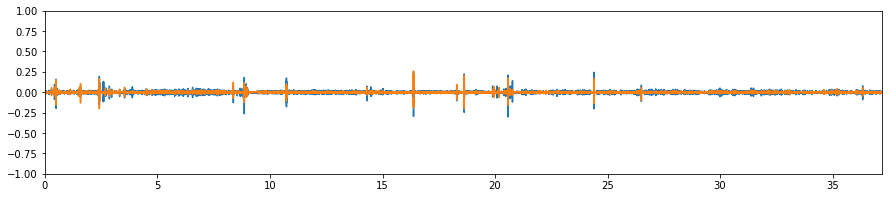

This cell took 355 seconds to run


In [7]:
# Plotting audio signal - channel 1 only
startTime = datetime.datetime.now()

import matplotlib.pyplot as plt
%matplotlib inline

channel = 0
t = [i/(fs*60) for i in range(len(data))]
sig = [i/32768 for i in data[:, channel]]
sig2 = [i/32768 for i in dataEmphasized[:, channel]]

fig, ax = plt.subplots(figsize=(15, 3))

ax.set_xlim([0, t[-1]])
ax.set_ylim([-1, 1])

ax.plot(t, sig)
ax.plot(t, sig2)
#plt.savefig("audiosignal.svg")
plt.show()

endTime = datetime.datetime.now()
totalTime = endTime - startTime
print("This cell took {:,} seconds to run".format(totalTime.seconds))

## Feature Extraction <label id="featExtraction">

The only preprocessing step carried out in this notebook is the feature extraction.  Speech activity detection (SAD) is done using the oracle segments file as done in Section [Segmentation] below.  No speech enhancement methods are applied.

Feature extraction generally involves framing and windowing before extracting specific features.  Typically, a frame of 20-30 ms would be taken and windowed, with 10 ms shifts between frames.  In this notebook, a frame of 30 ms (i.e. 480 samples) is typically used, with 10 ms (160 samples) shifts between frames.  The relevant feature extraction method used will also require some window to be used, which is the Hamming window unless otherwise specified.

In [8]:
len(data)/160

223165.86875

DiarTk uses 223,163 frames, which makes sense as each frame should be 30 ms long but the ones at either end would be truncated.

By far the most popular speech features extracted are <span style="color:brown;">Mel-frequency cepstral coefficients (MFCCs)</span>.  There are numerous variations and options involved, so this notebook is limited to [WHAT?].

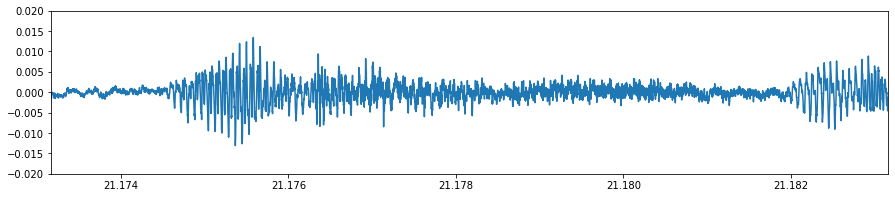

This cell took 2 seconds to run


In [9]:
# Illustrating windows
startTime = datetime.datetime.now()

import matplotlib.pyplot as plt
%matplotlib inline

channel = 0
points = 9600
startFrame = 127039
t = [i/(fs*60) for i in range(startFrame * 160, startFrame * 160 + points)]
sig = [i/32768 for i in data[startFrame * 160: startFrame * 160 + points, channel]]

fig, ax = plt.subplots(figsize=(15, 3))

ax.set_xlim([t[0], t[-1]])
ax.set_ylim([-0.02, 0.02])

ax.plot(t, sig)
#plt.savefig("audiosignal.svg")
plt.show()

endTime = datetime.datetime.now()
totalTime = endTime - startTime
print("This cell took {:,} seconds to run".format(totalTime.seconds))

### DiarTk Example

The DiarTk code comes with example MFCCs and TDOAs, but with no guidance on how they were generated.  These files are analysed below to give an initial idea of what is done before we look at generating them ourselves.

In [31]:
# Code from https://github.com/danijel3/PyHTK
# Need to import both the HTK.py and HTKFeat.py files from the python folder
from HTK import HTKFile
import numpy as np

htk_reader = HTKFile()
htk_reader.load("AMI_20050204-1206.fea")
result = np.array(htk_reader.data)
result

CRC checking not implememnted...


array([[ 3.70516014, -0.614775  , -3.83298707, ..., -0.49089277,
        -1.78284943, -0.70875895],
       [ 3.596071  , -1.91713011, -3.75054264, ..., -0.07009748,
        -4.32811832, -1.81178975],
       [ 3.36830068, -2.25451946, -2.76358891, ..., -1.85910928,
        -2.24971867, -0.48322296],
       ...,
       [-2.45173645, -3.01717901,  4.94650793, ...,  4.09425259,
        -0.16938451,  1.21592486],
       [-2.87442398, -2.2393012 ,  8.15914345, ...,  5.19428968,
         1.21401072, -0.74868804],
       [-5.34986115, -2.19008875,  7.44576788, ...,  3.90385127,
         0.28954843,  0.62065196]])

In [11]:
result.shape

(223163, 19)

In [12]:
import pandas as pd

#Probably better to add zeroes for first and last two so clear tie-in with time graph

df = pd.DataFrame(result, columns=[i + 1 for i in range(19)], index=[i + 1 for i in range(223163)])
df.head(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,3.705160,-0.614775,-3.832987,-11.171869,3.845937,-3.774527,4.082798,-13.120669,-1.086722,-3.961327,9.266994,-3.657100,0.865794,-7.310349,-0.362975,-1.413728,-0.490893,-1.782849,-0.708759
2,3.596071,-1.917130,-3.750543,-8.438622,4.814070,-6.234247,-1.550491,-17.829420,1.271162,-7.811125,5.441245,-4.691085,-5.004891,-8.729750,-0.064356,-1.000213,-0.070097,-4.328118,-1.811790
3,3.368301,-2.254519,-2.763589,-5.663739,3.936425,-7.172398,-4.517790,-14.480041,8.442841,-4.176378,1.120383,-11.850246,-5.018045,-3.193852,-0.031532,-5.046468,-1.859109,-2.249719,-0.483223
4,3.991493,-5.238074,-2.431599,-2.923549,2.170535,-14.528117,-4.656413,-6.032278,6.709707,-7.841902,-3.571587,-8.766372,-2.523466,-1.041626,0.659361,-6.825243,-0.363681,-2.591225,-1.534740
5,4.015254,-7.449009,-2.853654,-3.491647,-1.181447,-20.639490,-2.088737,-4.011966,2.167678,-13.377257,2.555011,-6.553562,-3.643952,-5.089597,-1.842345,-4.589858,1.547042,-1.639438,-3.186126
6,4.088393,-8.214425,-0.170540,1.035790,-2.466397,-15.101242,5.388036,0.707834,3.142563,-11.325600,4.551348,-0.691798,-1.382777,-8.285681,-0.607715,-3.290154,0.990803,-0.676973,-2.167771
7,2.121190,-6.814706,1.310231,-0.367486,-2.520288,-21.152834,6.842563,0.802346,3.619970,-6.562792,10.474594,-2.385100,-0.148052,-4.120584,4.370499,-1.260433,0.194308,-2.563437,-2.398462
8,1.060565,-7.759680,3.691145,-1.420488,-3.427601,-20.349253,6.964988,0.394821,1.639458,-9.521148,8.505016,-3.213260,-1.234453,-3.933805,6.369763,-0.629132,-0.348719,-2.782857,-1.121048
9,0.688181,-8.678029,2.766871,-1.151344,-4.613319,-19.465990,6.209901,-0.884852,0.767403,-8.622436,7.662519,-3.708668,-0.693395,-3.007268,4.675422,-4.506130,-2.886034,-4.600609,-1.285862
10,0.681903,-6.819816,5.264297,0.615418,-3.692865,-20.739599,10.195145,-1.951808,5.539105,-9.413551,4.758597,2.127125,1.628304,-0.964237,4.645388,-5.186583,-5.063208,-2.783296,0.091722


In [13]:
df.tail(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
223154,-2.265007,-3.787893,0.719568,-8.630719,2.200239,-4.765984,6.710692,-2.971904,7.005323,1.294309,5.223445,-4.638178,3.797339,0.058560,1.327341,1.685130,2.444618,1.584354,1.490175
223155,-1.990661,-1.860081,3.548644,-3.515744,5.708204,-4.417064,3.538510,-3.384956,10.513522,-0.897547,5.861310,-6.002229,3.535482,-0.858258,-0.117954,-2.754951,6.471069,0.520763,-0.054734
223156,-2.720546,-3.110494,3.292853,-1.525706,8.485035,-3.146978,3.186992,-4.767175,11.200892,-2.454504,3.331505,-5.997171,-0.684763,-2.651484,-0.076757,-2.632242,1.808280,0.448952,0.809735
223157,-2.211315,-3.093592,2.087055,-3.082214,8.163781,-6.383689,0.186887,-4.922688,9.446338,0.325330,9.014139,0.220393,1.849507,-2.666978,2.248187,-0.355673,4.434064,0.162695,0.959002
223158,-5.200091,-4.878437,3.369729,-5.479812,7.911566,-5.331159,1.043402,-5.137117,5.678912,-1.888140,7.756773,-3.832236,4.184433,0.364963,2.336577,-1.252724,1.756622,-0.754080,0.332033
223159,-4.246261,-4.089406,5.176991,-3.063068,7.629108,-5.914068,5.975288,0.447779,10.162134,0.913041,10.420712,0.485849,5.752440,0.332960,4.527809,2.255266,1.652858,-1.723135,0.448009
223160,-3.028871,-5.285967,7.155854,-4.272537,6.553968,-2.980027,7.952534,-0.710569,6.894428,-1.782571,7.464867,-2.464757,7.263648,-0.671436,5.283478,4.446611,1.213612,0.071522,0.686491
223161,-2.451736,-3.017179,4.946508,-1.889001,10.131855,0.181249,2.838942,-6.939662,10.352848,2.653862,10.533422,5.683698,6.990284,-5.181987,3.904603,2.393180,4.094253,-0.169385,1.215925
223162,-2.874424,-2.239301,8.159143,-1.346891,9.257104,-3.249623,2.858387,-3.395380,7.364421,-0.464038,6.026513,-1.040683,2.412831,-4.350496,4.103058,1.322142,5.194290,1.214011,-0.748688
223163,-5.349861,-2.190089,7.445768,-3.111451,9.889832,-5.012108,6.747571,-4.038531,6.540767,-2.326381,10.569186,0.834879,9.008770,-5.276912,3.680907,0.034791,3.903851,0.289548,0.620652


In [14]:
df.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')

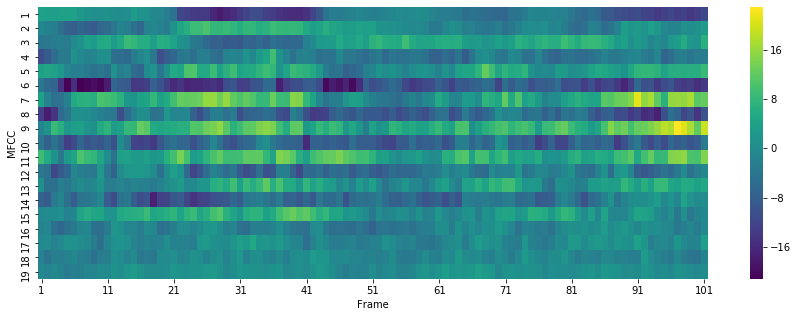

In [15]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(df[:101].T, xticklabels=10, cmap="viridis")
ax.set(xlabel='Frame', ylabel='MFCC')
plt.show()

It is usual to start counting at frame 0 rather than frame 1 in computer arrays.  However, as we have effectively cut out the very first frame [EXPLAIN] we are starting at frame 1 to avoid confusion.  [CHECK]

### 10 Seconds Extract
To give an idea of how many calculations are involved, the graph below shows a 10 second segment at the start of the analysed portion of the speech.  The transcripts are available from the AMI corpus in .xml file format.

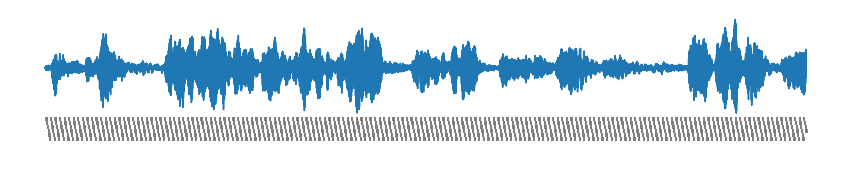

In [16]:
# 10 secs demo piece with s and x blocks
import matplotlib.pyplot as plt
import matplotlib.patches as patches

startTime = 1270.39
extractStartSample = int(startTime * 16000)
shortExtract = data[extractStartSample: extractStartSample + 10*16000, 4]
t = np.linspace(0, len(shortExtract)/16000, num=len(shortExtract))
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(t, shortExtract)
ax.set_ylim([-2500, 1500])
ax.axis('off')

xcoordsStart = []
xcoordsEnd = []
count = 0
for xc in xcoordsStart:
    plt.axvline(x = xc, linewidth=0.5, color="gray", linestyle="dashed")
#for xc in xcoordsEnd:
    #plt.axvline(x = xc, color="pink", linestyle="dashed")

for num in range(10*100):
    #count += 1
    rect = patches.Rectangle((num * 0.01, - 1300 - (num % 6) * 100), 0.03, 100, linewidth=0, edgecolor='k', facecolor='gray', capstyle='round')
    ax.add_patch(rect)
    
plt.show()

### Bespoke MFCCs

In [17]:
# Installing the python_speech_features library led to many package conflicts, so a separate environment was set up
# Changing kernels means the entire notebook is restarted, so need to run all notebook in new kernel
from python_speech_features import mfcc
#from python_speech_features import logfbank

mfccs = mfcc(data[:, 4], fs, winlen=0.03, winstep=0.01, numcep=19, appendEnergy=False)
mfccsEmphasized = mfcc(dataEmphasized[:, 4], fs, winlen=0.03, winstep=0.01, numcep=19, appendEnergy=False)

In [18]:
# Look at size of MFCC features matrix
mfccs.shape

(223164, 19)

In [19]:
# Remove last rows for consistency with DiarTk frames
mfccs = mfccs[:-1, :]
mfccsEmphasized = mfccsEmphasized[:-1, :]
mfccs.shape

(223163, 19)

In [20]:
import GenerateDeltas

deltas = GenerateDeltas.calcDeltas(mfccs)
deltasEmphasized = GenerateDeltas.calcDeltas(mfccsEmphasized)
deltas.shape

(223163, 19)

In [21]:
deltaDeltas = GenerateDeltas.calcDeltaDeltas(deltas)
deltaDeltasEmphasized = GenerateDeltas.calcDeltaDeltas(deltasEmphasized)
deltaDeltas.shape

(223163, 19)

In [22]:
import numpy as np

mfccsD2 = np.concatenate((mfccs, deltas, deltaDeltas), axis=1)
mfccsD2Emphasized = np.concatenate((mfccsEmphasized, deltasEmphasized, deltaDeltasEmphasized), axis=1)
mfccsD2.shape

(223163, 57)

I did not manage to find any Python code for writing HTK files that I could get to work, so I wrote some simple code that does not contain any options.

In [23]:
import WriteHtk

WriteHtk.writeHtkFile(mfccsD2, 100000, "mfccsD2.fea", 6)
WriteHtk.writeHtkFile(mfccsD2Emphasized, 100000, "mfccsD2Emphasized.fea", 6)

The file size is 49,689 kB.
The file size is 49,689 kB.


The MFCC file provided by DiarTk looks rather different.  I need to (a) try generating MFCCs for each of the Array 1 microphones and (b) see if saving the DiarTk MFCCs using my HTK function and then running DiarTk on that gives 8.79%.  [FOLLOW UP]

In [24]:
mfcc_feats = []
for i in range(8):
    mfcc_feats.append(mfcc(data[:, i], fs))
    
mfcc_feats = np.array(mfcc_feats)
print(mfcc_feats.shape)

(8, 223165, 13)


In [25]:
for i in range(len(mfcc_feats)):
    print(mfcc_feats[i, 1, :])

[  9.77098336   2.67776447  -9.41596717  -5.04135257 -15.52728412
  11.42664252  -6.9129593    2.81639295 -21.13877391  11.9264274
  -3.48599387  14.31708749  -4.54036346]
[ 10.70552849   5.83112498 -12.3795424   -7.36408343 -14.96116305
  10.38289102  -7.49018904   4.7783849  -27.09457803   9.50604885
  -2.75714512  16.81188052   1.46786647]
[ 11.34157818   6.22203861 -10.81108154  -6.98177823 -16.72959133
  10.20703181 -10.29619319  -1.1320458  -29.39285673   9.19263115
  -6.28864377  17.12691053  -1.5906697 ]
[ 10.63114444   5.77066825  -6.93315821  -6.42280794 -14.06063094
   7.2385619  -12.31427782  -0.19154213 -23.94446672   5.20395865
  -5.40655797  16.29604857   2.72120175]
[ 10.22266433   4.0712544   -8.8547624   -4.72922912 -20.24580775
   9.88292452  -3.45949116   7.71575556 -17.86067849   0.66352875
  -7.44613625  19.19146757   0.59084648]
[  9.87009584   3.64694935 -10.02282919  -6.27881382 -16.23948886
  13.26317332   0.15411856  16.4234294  -16.0675732    6.24523883
  -7

In [27]:
#writeHtkFile(result, 100000, "test3.fea")

In [28]:
filename = "AMI_20050204-1206.fea"
htk_reader.load(filename)
print(htk_reader.nSamples)
print(htk_reader.nFeatures)
print(htk_reader.sampPeriod)
print(htk_reader.basicKind)
print(htk_reader.qualifiers)
print(htk_reader.endian)

CRC checking not implememnted...
223163
19
100000
MFCC
['K']
>


<h2 style="counter-reset:h3counter;">Segmentation</h2> <label id="speechSegments">

Segmentation involves splitting up an speech signal into segments that are in some way distinguishable from the immediately preceding segment (e.g. a speaker change boundary or a speaker-silence boundary).  There is significant overlap between SAD and segmentation, and a comprehensive segmentation method would address SAD as well.  Some speaker diarization methods, such as unsupervised clustering methods, only need the segmentation to distinguish between speech and non-speech, whereas others would need speaker-change boundaries to be identified as well.
    
DiarTK is an unsupervised clustering method, so the segmentation merely needs to distinguish between speech frames and non-speech frames.  We could use and test specific software to do this, though for the time being we will use the oracle speech segments file as DiarTk can easily determine the speech frames and non-speech frames from that.  This file is in .scp format, which is essentially a text file set up in a specific manner.

### Using Oracle .scp Segments File

In [29]:
filename = "AMI_20050204-1206.scp"
lineCount = 0
with open(filename, "r") as f:
    for line in f:
        lineCount += 1
        if lineCount <= 5:
            print(line)
            
print("There are {} distinct speaker segments in that file.".format(lineCount))

../AMI_20050204-1206_127039_127488=/idiap/user/shyella/data/ami/feat/headmix/../AMI_20050204-1206.fea[127039,127488]

../AMI_20050204-1206_127519_127826=/idiap/user/shyella/data/ami/feat/headmix/../AMI_20050204-1206.fea[127519,127826]

../AMI_20050204-1206_127520_127563=/idiap/user/shyella/data/ami/feat/headmix/../AMI_20050204-1206.fea[127520,127563]

../AMI_20050204-1206_127874_128451=/idiap/user/shyella/data/ami/feat/headmix/../AMI_20050204-1206.fea[127874,128451]

../AMI_20050204-1206_128498_128826=/idiap/user/shyella/data/ami/feat/headmix/../AMI_20050204-1206.fea[128498,128826]

There are 333 distinct speaker segments in that file.


These segments are more easily analysed in numerical matrix form.  Note also that these speaker segments do not identify specific speakers.

In [30]:
# Use a bespoke function to extract the segments
# Only the first 10 segments printed below

import OverlapFunctions

segments = OverlapFunctions.getSegs(filename)
for i in range(5):
    print(segments[i])

[127039, 127488]
[127519, 127826]
[127520, 127563]
[127874, 128451]
[128498, 128826]


When we come to run the DiarTk code in Section [ ] below, we find that DiarTk sets a maximum segment length of 2.5 seconds, which is 250 frames.  [SET OUT EXAMPLE?]

In [31]:
# We can see that many of these segments overlap
# At this stage, we only care about whether there is a speaker or not, so combine overlapping and adjoining segments

combinedSegments = OverlapFunctions.findCombinedSegs(segments)
[print(combinedSegments[0][i]) for i in range(5)]

[127039, 127488]
[127519, 127826]
[127874, 128451]
[128498, 128826]
[128893, 129123]


[None, None, None, None, None]

This list of combined segments simplifies showing the speech regions on a graph.  Note that only a small section of the audio file is considered.

In [32]:
print("The range of segments analysed runs from segment {:,} to segment {:,}, inclusive.".format(combinedSegments[0][0][0], combinedSegments[0][-1][1]))

The range of segments analysed runs from segment 127,039 to segment 198,312, inclusive.


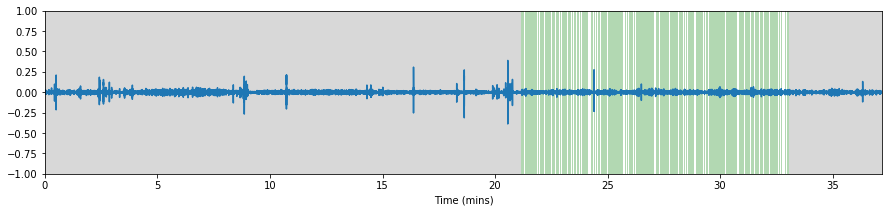

In [33]:
# Plotting audio signal and speech segments - channel 1 only

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

t = [i/(fs * 60) for i in range(len(data))]
sig = [i/32768 for i in data[:, 1]]

fig, ax = plt.subplots(figsize=(15, 3))

ax.set_xlim([0, t[-1]])
ax.set_ylim([-1, 1])

ax.plot(t, sig)
#plt.savefig("audiosignal.svg")

#Grey out ignored regions at start and finish
rect = mpatches.Rectangle(
    xy=(0, -1),
    width=(combinedSegments[0][0][0] - 1) * 0.01/60,
    height=2,
    facecolor="gray",
    alpha=0.3)
ax.add_patch(rect)

rect = mpatches.Rectangle(
    xy=((combinedSegments[0][-1][1]) * 0.01/60, -1),
    width=t[-1] - (combinedSegments[0][-1][1]) * 0.01/60,
    height=2,
    facecolor="gray",
    alpha=0.3)
ax.add_patch(rect)

#Show analysed speaker parts in green
for row in combinedSegments[0]:
    rect = mpatches.Rectangle(
        xy=((row[0] - 1) * 0.01/60, -1),
        width=(row[1] - row[0]) * 0.01/60,
        height=2,
        facecolor="green",
        alpha=0.3)
    ax.add_patch(rect)

ax.set_xlabel("Time (mins)")
plt.show()

We now look at some specific aspects of the audio file analysed.

In [45]:
import math
#print("The length of the audiofile is {} mins {:3} secs.".format(mins, secs))

analysedLength = (combinedSegments[0][-1][1] + 1 - combinedSegments[0][0][0]) * 0.01
analysedLengthMins = math.floor(analysedLength/60)
analysedLengthSecs = round((analysedLength - 60 * analysedLengthMins)*100)/100
print("The length of the part analysed is {} mins {:3} secs.".format(analysedLengthMins, analysedLengthSecs))

speechTime = OverlapFunctions.countSegs(combinedSegments[0]) * 0.01
speechTimeMins = math.floor(speechTime/60)
speechTimeSecs = round((speechTime - 60 * speechTimeMins)*100)/100
print("The speech portion of the part analysed is {} mins {:3} secs.".format(speechTimeMins, speechTimeSecs))

The length of the part analysed is 11 mins 52.74 secs.
The speech portion of the part analysed is 9 mins 38.65 secs.


Now printing out the graph again but ignoring the greyed out areas at either end.

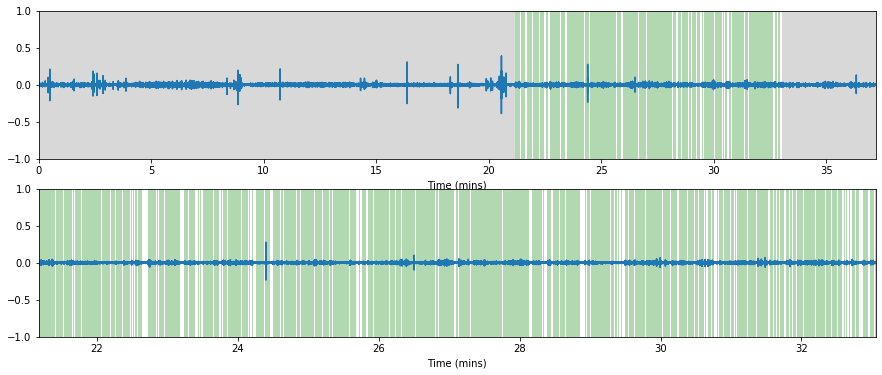

In [35]:
# Plotting audio signal and speech segments - channel 1 only

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

t = [i/(fs * 60) for i in range(len(data))]
sig = [i/32768 for i in data[:, 1]]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

ax1.set_xlim([0, t[-1]])
ax1.set_ylim([-1, 1])

ax1.plot(t, sig)
#plt.savefig("audiosignal.svg")

#Grey out ignored regions at start and finish
rect = mpatches.Rectangle(
    xy=(0, -1),
    width=(combinedSegments[0][0][0] - 1) * 0.01/60,
    height=2,
    facecolor="gray",
    alpha=0.3)
ax1.add_patch(rect)

rect = mpatches.Rectangle(
    xy=((combinedSegments[0][-1][1]) * 0.01/60, -1),
    width=t[-1] - (combinedSegments[0][-1][1]) * 0.01/60,
    height=2,
    facecolor="gray",
    alpha=0.3)
ax1.add_patch(rect)

#Show analysed speaker parts in green
for row in combinedSegments[0]:
    rect = mpatches.Rectangle(
        xy=((row[0] - 1) * 0.01/60, -1),
        width=(row[1] - row[0]) * 0.01/60,
        height=2,
        facecolor="green",
        alpha=0.3)
    ax1.add_patch(rect)

ax1.set_xlabel("Time (mins)")

ax2.set_xlim([1270.39/60, 1983.12/60])
ax2.set_ylim([-1, 1])

ax2.plot(t[127039*160: 198312*160], sig[127039*160: 198312*160])
#plt.savefig("audiosignal.svg")

#Show analysed speaker parts in green
for row in combinedSegments[0]:
    rect = mpatches.Rectangle(
        xy=((row[0] - 1) * 0.01/60, -1),
        width=(row[1] - row[0]) * 0.01/60,
        height=2,
        facecolor="green",
        alpha=0.3)
    ax2.add_patch(rect)

ax2.set_xlabel("Time (mins)")

plt.show()

[NEED TO FACTOR IN 2.5MS MAX - GET FROM dIARtK OUTPUT]

### 10 Second Extract

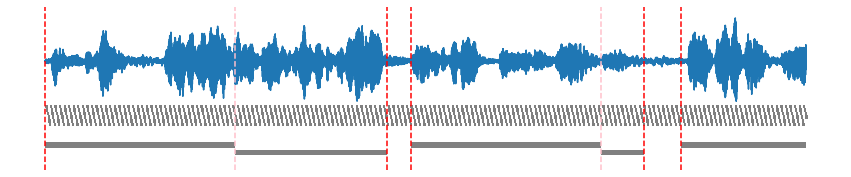

In [37]:
# 10 secs demo piece with s and x blocks
import matplotlib.patches as patches

startTime = 1270.39
extractStartSample = int(startTime * 16000)
shortExtract = data[extractStartSample: extractStartSample + 10*16000, 4]
t = np.linspace(0, len(shortExtract)/16000, num=len(shortExtract))
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(t, shortExtract)
ax.set_ylim([-3000, 1500])
ax.axis('off')

xcoordsStart = []
xcoordsEnd = []
count = 0
for xc in xcoordsStart:
    plt.axvline(x = xc, linewidth=0.5, color="gray", linestyle="dashed")
#for xc in xcoordsEnd:
    #plt.axvline(x = xc, color="pink", linestyle="dashed")

for num in range(10*100):
    #count += 1
    rect = patches.Rectangle((num * 0.01, - 1300 - (num % 6) * 100), 0.03, 100, linewidth=0, edgecolor='k', facecolor='gray', capstyle='round')
    ax.add_patch(rect)
    
count = 0
xcStart = [0, 2.5, 5.195-0.39, 5.195-0.39+2.5, 8.74-0.39]
xcEnd = [2.5, 4.49, 5.195-0.39+2.5, 5.195-0.39+3.07, 10]
for i in range(len(xcStart)):
    count += 1
    rect = patches.Rectangle((xcStart[i], -2400 - ((count - 1) % 2) * 200), xcEnd[i] - xcStart[i], 160, linewidth=0, edgecolor='k', facecolor='gray', capstyle='round')
    ax.add_patch(rect)
    
xcoords = [0, 4.49, 5.195-0.39, 5.195-0.39+3.07, 8.74-0.39]
for xc in xcoords:
    plt.axvline(x = xc, color="red", linestyle="dashed")
# Now adding in the split segments from DiarTk
xcoords2 = [2.5, 5.195-0.39+2.5]
for xc in xcoords2:
    plt.axvline(x = xc, color="pink", linestyle="dashed")
    
plt.show()

### Origin of Oracle .scp Segments Files
It is evident that the .scp files originate from the oracle .rttm speaker segment files.  It is helpful to look at the .rttm files as well to show where the .scp segment numbers start from.

In [38]:
filename = "AMI_20050204-1206.rttm"
lineCount = 0
with open(filename, "r") as f:
    for line in f:
        lineCount += 1
        if lineCount <= 10:
            print(line)

SPEAKER AMI_20050204-1206 1 1270.390 4.490 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1275.195 3.070 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1278.740 5.765 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1284.980 3.280 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1288.930 1.000 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1291.770 1.190 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1295.885 2.190 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1341.915 1.290 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1345.010 0.360 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1350.955 0.580 <NA> <NA> FEE029 <NA>



There are some useful observations to make comparing the .scp and .rttm files:
<ul>
    <li>The .rttm time borders are simply multiplied by 100 (to reflect the 10 ms frames) and then rounded down (if frame at start of segment) or up (if frame at end of segment) to give the .scp segments.</li>
    <li>If there had been a speaker segment starting at time 0, it would be segment number 0.  This means that the first .scp segment 127,039 is actually the 127,040<sup>th</sup> segment if counting from 1.  This could be relevant when analysing results later.</li>
</ul

### Generating From XML Files
The AMI Corpus sets out its oracle segments files in the AMI Corpus Manual.  These files are saved in <span class="monospace">.xml</span> format, so the segments need to be extracted from them and put into <span class="monospace">.scp</span> and <span class="monospace">.rttm</span> format as appropriate.

In [39]:
import XMLtoSegs

path = "segments"
meeting = "ES2008b"
fp = 0.01
(timeSegments, frameSegments, spkrs) = XMLtoSegs.AMIXMLtoSegs(path, meeting, fp)

The timeSegments come directly from the <span class="monospace">.wav</span> file.

In [40]:
timeSegments[:5]

[[49.68, 54.006, 'A', 'FEE029'],
 [58.208, 60.048, 'A', 'FEE029'],
 [61.056, 61.914, 'A', 'FEE029'],
 [63.027, 64.64, 'A', 'FEE029'],
 [66.752, 67.456, 'A', 'FEE029']]

The frameSegments are the timeSegments divided by fp (i.e. usually x 100), but start frame floored and end frame ceilinged.

In [41]:
frameSegments[:5]

[[4968, 5401, 'A'],
 [5820, 6005, 'A'],
 [6105, 6192, 'A'],
 [6302, 6464, 'A'],
 [6675, 6746, 'A']]

The generateSCP_RTTM module contains functions that save the segments in suitable .scp and .rttm formats.

In [42]:
import generateSCP_RTTM

generateSCP_RTTM.saveSCPFile("scp", meeting, frameSegments)
generateSCP_RTTM.saveRTTMFile("rttm", meeting, timeSegments)

## Labelling <label id="labelling">

The labelling step\footnote{Also known as classification.} involves classifying each speech frame or segment according to some specific characteristic.  For example, if there is no separate SAD, individual frames could be characterised as either speech, noise or silence.  Individual frames could also be labelled as belonging to specific speakers, but more likely a number of speech frames would need to be considered together to obtain enough information to be characterised as belonging to a particular speaker \cite{Zhang2018}.

With supervised systems, segments attributed to particular speakers can easily be clustered together and form part of the set of one speaker.  There is no real need for a separate clustering step here.  By contrast, with unsupervised systems, there is generally no labelling involved so the relevant clustering method is used to cluster segments together and then assign a generic speaker label.

More importantly for this research, semi-supervised systems will likely involve both labelling and clustering.  Specific speech segments can either be identified as belonging to a particular known speaker or not, and if not then the clustering approach would come in to identify how many unknown speakers there are and establish new models for them.  A good system would then allow the user to input the names of the new speakers, if known, and then the model will be able to identify those speakers if heard again subsequently (this leads on to online speaker diarization discussed in Section \ref{ss:OnlineSpeakerDiarization}).

## Clustering <label id="runDiarTk">

Clustering involves clustering together the individual segments to identify particular speakers.  The method used will depend on the segmentation and labelling process used, and much of the literature does not distinguish the segmentation, labelling and clustering steps.

Clustering is usually done in either a supervised manner, where the model is trained on data that is known to be in a particular cluster (e.g. k-nearest neighbours (KNN)), or an unsupervised manner, where the model is not previously trained (e.g. k-means clustering).  As open-set speaker recognition is important for this research, the focus will need to be on semi-supervised systems going forward (see Section \ref{ss:OnlineSpeakerDiarization} for more details).

The approaches to unsupervised clustering are classfied into top-down and bottom-up approaches.  Top-down approaches start off with a single cluster and then gradually separate out distinct speaker clusters, whereas bottom-up approaches (such as agglomerative information bottlenecks used by DiarTk and discussed in Section \ref{ss:InformationBottleneckTheory}) start with many clusters and gradually combine them to show the distinct speaker clusters.

Some systems (e.g. <cite data-cite="6354852/EVMWQLE2"></cite>, [<a href="#vijayasenan2012">2</a>]) refer to realigning speaker segments after the clustering step using the Viterbi algorithm to improve the segmentation.  This would not be necessary if the speaker segments are already well defined and the clustering is limited to attributing speaker segments to individual speakers.

### Running DiarTk

In [3]:
!bash run.diarizeme.sh AMI_20050204-1206.fea AMI_20050204-1206.scp results AMI_20050204-1206

Testing!
-----------------------------------Initialize HMM


In [ ]:
!bash run.diarizeme.sh test2.fea AMI_20050204-1206.scp resultsTest AMI_20050204-1206

In [ ]:
!bash run.diarizeme.sh test3.fea AMI_20050204-1206.scp resultsTest3 AMI_20050204-1206

In [ ]:
outputDir = "results/mfccsD2/"

!bash run.diarizeme.sh mfccsD2.fea AMI_20050204-1206.scp $outputDir AMI_20050204-1206

for filename in os.listdir(outputDir):
    if outputDir[-1] != "/":
        outputDir += "/"
    if filename.find(".rttm") == -1 and filename.find(".scp") == -1:
        file = outputDir + filename
        print(file)
        !rm $file

In [ ]:
outputDir = "results/mfccsD2Emphasized"

!bash run.diarizeme.sh mfccsD2Emphasized.fea AMI_20050204-1206.scp $outputDir AMI_20050204-1206

for filename in os.listdir(outputDir):
    if outputDir[-1] != "/":
        outputDir += "/"
    if filename.find(".rttm") == -1 and filename.find(".scp") == -1:
        file = outputDir + filename
        print(file)
        !rm $file

DiarTk produces a number of files in the process.  In the order they are produced, these are:
<ul>
    <li>.out</li>
</ul>

The last of these is the all-important allocated segments file and is inspected closely below.

In [4]:
# Printing the first 10 lines
filename = "results/AMI_20050204-1206.rttm"
lineCount = 0
with open(filename, "r") as f:
    for line in f:
        lineCount += 1
        if lineCount <= 10:
            print(line)

SPEAKER AMI_20050204-1206 1 1270.39 4.50 <NA> <NA> AMI_20050204-1206_spkr_0 <NA>

SPEAKER AMI_20050204-1206 1 1275.19 3.08 <NA> <NA> AMI_20050204-1206_spkr_0 <NA>

SPEAKER AMI_20050204-1206 1 1278.74 5.78 <NA> <NA> AMI_20050204-1206_spkr_0 <NA>

SPEAKER AMI_20050204-1206 1 1284.98 3.29 <NA> <NA> AMI_20050204-1206_spkr_0 <NA>

SPEAKER AMI_20050204-1206 1 1288.93 2.31 <NA> <NA> AMI_20050204-1206_spkr_0 <NA>

SPEAKER AMI_20050204-1206 1 1291.77 0.51 <NA> <NA> AMI_20050204-1206_spkr_0 <NA>

SPEAKER AMI_20050204-1206 1 1292.28 1.12 <NA> <NA> AMI_20050204-1206_spkr_3 <NA>

SPEAKER AMI_20050204-1206 1 1293.99 0.26 <NA> <NA> AMI_20050204-1206_spkr_3 <NA>

SPEAKER AMI_20050204-1206 1 1294.50 1.03 <NA> <NA> AMI_20050204-1206_spkr_3 <NA>

SPEAKER AMI_20050204-1206 1 1295.57 0.09 <NA> <NA> AMI_20050204-1206_spkr_3 <NA>



In [5]:
# Comparing to the oracle segments file
filename = "AMI_20050204-1206.rttm"
lineCount = 0
with open(filename, "r") as f:
    for line in f:
        lineCount += 1
        if lineCount <= 10:
            print(line)
            
oracleSegments = []
with open(filename, "r") as f:
    for line in f:
        lineItems = line.split(" ")
        oracleSegments.append([float(lineItems[3]), round(float(lineItems[3]) + float(lineItems[4]), 2), lineItems[7]])
oracleSegments[:10]

SPEAKER AMI_20050204-1206 1 1270.390 4.490 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1275.195 3.070 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1278.740 5.765 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1284.980 3.280 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1288.930 1.000 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1291.770 1.190 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1295.885 2.190 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1341.915 1.290 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1345.010 0.360 <NA> <NA> FEE029 <NA>

SPEAKER AMI_20050204-1206 1 1350.955 0.580 <NA> <NA> FEE029 <NA>



[[1270.39, 1274.88, 'FEE029'],
 [1275.195, 1278.26, 'FEE029'],
 [1278.74, 1284.51, 'FEE029'],
 [1284.98, 1288.26, 'FEE029'],
 [1288.93, 1289.93, 'FEE029'],
 [1291.77, 1292.96, 'FEE029'],
 [1295.885, 1298.08, 'FEE029'],
 [1341.915, 1343.2, 'FEE029'],
 [1345.01, 1345.37, 'FEE029'],
 [1350.955, 1351.53, 'FEE029']]

In [6]:
import pandas as pd

dfOracleSegments = pd.DataFrame(oracleSegments, columns=["StartTime", "EndTime", "Speaker"])
set(dfOracleSegments["Speaker"])

{'FEE029', 'FEE030', 'FEE032', 'MEE031'}

In [7]:
enumOracleSpeakers = []
for c, value in enumerate(set(dfOracleSegments["Speaker"]), 1):
    enumOracleSpeakers.append([c - 1, value])
enumOracleSpeakers = pd.DataFrame(enumOracleSpeakers, columns=["Number", "Speaker"])
enumOracleSpeakers

,Number,Speaker
0,0,FEE030
1,1,FEE029
2,2,MEE031
3,3,FEE032


In [8]:
enumOracleSpeakers[enumOracleSpeakers["Speaker"] == "FEE029"]

,Number,Speaker
1,1,FEE029


In [9]:
int(enumOracleSpeakers[enumOracleSpeakers["Speaker"] == "FEE029"]["Number"])

1

In [10]:
enumOracleSpeakers.iloc[0]["Speaker"]

'FEE030'

In [11]:
# Looking at number of speakers identified by DiarTk
filename = "results/AMI_20050204-1206.rttm"
speakers = []
with open(filename, "r") as f:
    for line in f:
        lineItems = line.split(" ")
        if lineItems[7] not in speakers:
            speakers.append(lineItems[7])

for row in speakers:
    print(row)
print("{} distinct speakers were identified by DiarTk.".format(len(speakers)))

AMI_20050204-1206_spkr_0
AMI_20050204-1206_spkr_3
AMI_20050204-1206_spkr_5
AMI_20050204-1206_spkr_6
AMI_20050204-1206_spkr_1
AMI_20050204-1206_spkr_9
6 distinct speakers were identified by DiarTk.


In [12]:
filename = "results/AMI_20050204-1206.rttm"
segments = []
with open(filename, "r") as f:
    for line in f:
        lineItems = line.split(" ")
        segments.append([float(lineItems[3]), round(float(lineItems[3]) + float(lineItems[4]), 2), int(lineItems[7][-1])])

segments[:10]

[[1270.39, 1274.89, 0],
 [1275.19, 1278.27, 0],
 [1278.74, 1284.52, 0],
 [1284.98, 1288.27, 0],
 [1288.93, 1291.24, 0],
 [1291.77, 1292.28, 0],
 [1292.28, 1293.4, 3],
 [1293.99, 1294.25, 3],
 [1294.5, 1295.53, 3],
 [1295.57, 1295.66, 3]]

In [13]:
import pandas as pd
df = pd.DataFrame(segments, columns=["StartTime", "EndTime", "Speaker"])
speakers = set(df["Speaker"])
speakers

{0, 1, 3, 5, 6, 9}

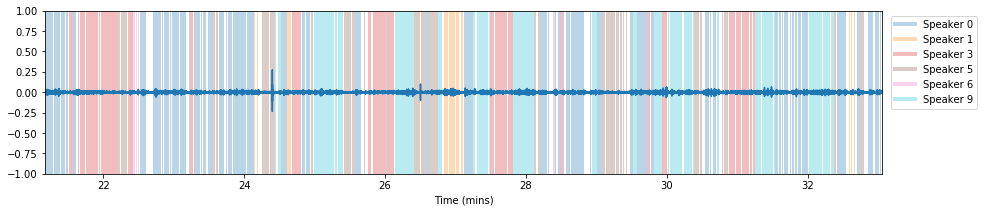

In [14]:
# Plotting audio signal and speech segments - channel 1 only

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
%matplotlib inline

t = [i/(fs * 60) for i in range(len(data))]
sig = [i/32768 for i in data[:, 1]]

fig, ax = plt.subplots(figsize=(15, 3))

ax.set_xlim([1270.39/60, 1983.12/60])
ax.set_ylim([-1, 1])

ax.plot(t[127039*160: 198312*160], sig[127039*160: 198312*160])
#plt.savefig("audiosignal.svg")

#Show analysed speaker parts in green
for row in segments:
    #print(row)
    rect = mpatches.Rectangle(
        xy=((row[0] - 1)/60, -1),
        width=(row[1] - row[0])/60,
        height=2,
        facecolor="C"+str(row[2]),
        alpha=0.3)
    ax.add_patch(rect)

ax.set_xlabel("Time (mins)")

legend_elements = []
for i in range(10):
    if i in speakers:
        legend_elements.append(Line2D([0], [0], color="C"+str(i), lw=4, label="Speaker "+str(i), alpha=0.3))

ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.12,1))
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)

plt.show()

There were actually only four speakers, so using the oracle speaker segments .rttm file gives the following.

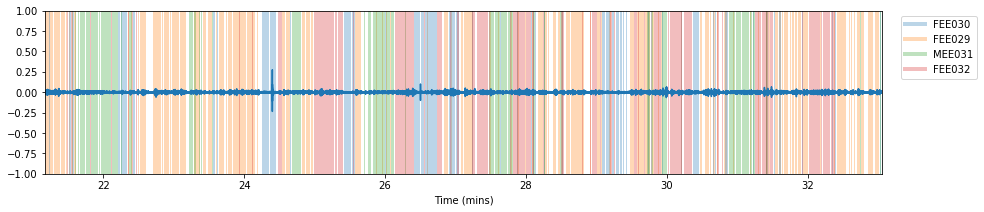

In [15]:
# Plotting audio signal and speech segments

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
%matplotlib inline

t = [i/(fs * 60) for i in range(len(data))]
sig = [i/32768 for i in data[:, 1]]

fig, ax = plt.subplots(figsize=(15, 3))

ax.set_xlim([1270.39/60, 1983.12/60])
ax.set_ylim([-1, 1])

ax.plot(t[127039*160: 198312*160], sig[127039*160: 198312*160])
#plt.savefig("audiosignal.svg")

#Show analysed speaker parts in green
for row in oracleSegments:
    #print(row)
    rect = mpatches.Rectangle(
        xy=((row[0] - 1)/60, -1),
        width=(row[1] - row[0])/60,
        height=2,
        facecolor="C"+str(int(enumOracleSpeakers[enumOracleSpeakers["Speaker"] == row[2]]["Number"])),
        alpha=0.3)
    ax.add_patch(rect)

ax.set_xlabel("Time (mins)")

legend_elements = []
for i in range(4):
    if i in set(enumOracleSpeakers["Number"]):
        legend_elements.append(Line2D([0], [0], color="C"+str(i), lw=4, label=enumOracleSpeakers.iloc[i]["Speaker"], alpha=0.3))

ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.12,1))
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)

plt.show()

Comparing the colours in the graphs above, we can see that the most likely mapping of speakers is FEE029 to Speaker 0, MEE031 to Speaker 3, FEE030 to Speaker 5 and FEE032 to Speaker 9.  [COMPLETE].

We can now try putting these on the same graph - oracle on top and DiarTk below.

## Evaluate Results <label id="evaluate">

The most widely used programme that calculates speaker diarization error rates (DER) is version 21 of the Perl script <span class="monospace">md-eval-v21.pl</span> published by the National Institute of Standards and Technology (NIST, which is now part of the United States Department of Commerce) and described at <cite data-cite="6354852/5UBMPPWU"></cite>.

NIST ran a number of Rich Transcription Meeting Recognition challenges from 2002 to 2009.  To evaluate the results, NIST established a standard methodology for various aspects, including for speaker diarization (see Section 6 of <cite data-cite="6354852/5UBMPPWU"></cite>).  The NIST evaluation tool calculates the DER using

<p style="text-align:center;">$\small DER = \large\frac{FA + MISS + ERROR}{TOTAL}$,</p>

where: $\small FA$ is the false alarm time, which is the aggregate amount of time allocated to speakers when they were not speaking; $\small{MISS}$ is the missed time, which is the aggregate amount of time that should have been recorded to a speaker but was not recorded; and $\small{ERROR}$ is the confusion time, which is the aggregate amount of time attributed to the wrong speaker; and $\small{TOTAL}$ is the total speaker time, which can be longer than the full length of the speech file because overlapping speech is attributed separately to the people who are speaking during that segment (there is no double-counting as the numerator also reflects the relevant time components).

The NIST evaluation tool permits the use of un-partitioned evaluations maps (UEM) files, which tell the tool which segments to ignore.  These were originally used to identify segments of overlapping speakers that should be ignored, which significantly improved results, but are now much more limited and often not used at all.  The NIST evaluation tool also contains a forgiveness collar that specifies a region around speaker change boundaries that should not be evaluated.  It was initially common to use $\small\pm0.25$ s here, though it is often dropped now.[UPDATE]

In [16]:
import os
import AnalyseResults
outputDir = "results/mfccsD2/"
audioname = "AMI_20050204-1206"
oracleRttmFile = "AMI_20050204-1206.rttm"
!bash evaluateResults.sh $outputDir $audioname $oracleRttmFile
AnalyseResults.getDERs(outputDir)

perl md-eval-v21.pl -m -afc -c 0.25 -r AMI_20050204-1206.rttm -s results/mfccsD2/AMI_20050204-1206.rttm > results/mfccsD2/NISTEvaluation_2_5.txt


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,25,2.09,0.00,6.10,8.20
1,20,2.93,0.00,6.57,9.50
2,15,4.07,0.00,7.18,11.25
3,10,5.39,0.00,7.96,13.35
4,5,6.98,0.00,8.93,15.91
5,0,8.74,0.35,9.92,19.01


In [17]:
outputDir = "results/mfccsD2Emphasized/"
audioname = "AMI_20050204-1206"
oracleRttmFile = "AMI_20050204-1206.rttm"
!bash evaluateResults.sh $outputDir $audioname $oracleRttmFile
AnalyseResults.getDERs(outputDir)

perl md-eval-v21.pl -m -afc -c 0.25 -r AMI_20050204-1206.rttm -s results/mfccsD2Emphasized/AMI_20050204-1206.rttm > results/mfccsD2Emphasized/NISTEvaluation_2_5.txt


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,25,2.10,0.00,5.40,7.50
1,20,2.93,0.00,5.98,8.91
2,15,4.07,0.00,6.64,10.72
3,10,5.39,0.00,7.50,12.90
4,5,6.98,0.00,8.53,15.51
5,0,8.74,0.35,9.57,18.66


Using the emphasized signal gives significantly better results!

[As DiarTk identified six speakers instead of the actual four, it is worth seeing how these were mapped by the NIST evaluation code.][Update and sort out previous test results such as one below]

In [18]:
for outputDir in ["results/mfccsD2/", "results/mfccsD2Emphasized/"]:
    print(outputDir)
    print(AnalyseResults.getMappings(outputDir))

results/mfccsD2/
results/mfccsD2/NISTEvaluation_0_0.txt
'fee029' => 'ami_20050204-1206_spkr_0'
   205.13 secs matched to 'ami_20050204-1206_spkr_0'
    14.23 secs matched to 'ami_20050204-1206_spkr_2'
    12.03 secs matched to 'ami_20050204-1206_spkr_4'
     3.09 secs matched to 'ami_20050204-1206_spkr_5'
     2.28 secs matched to 'ami_20050204-1206_spkr_8'
     7.71 secs matched to 'ami_20050204-1206_spkr_9'
'fee030' => 'ami_20050204-1206_spkr_2'
    13.72 secs matched to 'ami_20050204-1206_spkr_0'
    65.11 secs matched to 'ami_20050204-1206_spkr_2'
     7.83 secs matched to 'ami_20050204-1206_spkr_4'
     0.01 secs matched to 'ami_20050204-1206_spkr_5'
     7.75 secs matched to 'ami_20050204-1206_spkr_8'
     6.23 secs matched to 'ami_20050204-1206_spkr_9'
'fee032' => 'ami_20050204-1206_spkr_9'
    11.30 secs matched to 'ami_20050204-1206_spkr_0'
    10.40 secs matched to 'ami_20050204-1206_spkr_2'
     3.91 secs matched to 'ami_20050204-1206_spkr_4'
     1.34 secs matched to 'ami_2

## Create Transcript <label id="transcript">


In [19]:
import CreateTranscript # My library for extracting .xml transcript times

words = []
rowNumber = 0

filename = ["ES2008b.A.words.xml", "ES2008b.B.words.xml", "ES2008b.C.words.xml", "ES2008b.D.words.xml"]
for f in filename:
    file = open(f, "r")

    for line in file:
        if line.find("<w") != -1:
            # I get odd results with punctuation when sorting by speakers, so add punctuation to previous rows of same speaker
            if line.find("punc=") != -1:
                words[rowNumber - 1][2] += CreateTranscript.getWord(line)
            else:
                words.append([float(CreateTranscript.getStartTime(line)), float(CreateTranscript.getEndTime(line)), CreateTranscript.getWord(line), f[8]])
                rowNumber += 1

words.sort(key=lambda x:x[0])

wordsExtract = [] # 11 minute extract
for row in words:
    if row[0] >= 1270.39 and row[0] <= 1983.12:
        wordsExtract.append(row)

for row in wordsExtract:
    print(row)

[1270.42, 1270.9, 'Okay,', 'A']
[1270.9, 1271.95, 'requirements.', 'A']
[1271.95, 1272.07, 'We', 'A']
[1272.07, 1272.18, 'have', 'A']
[1272.18, 1272.21, 'a', 'A']
[1272.21, 1272.47, 'couple', 'A']
[1272.47, 1272.65, 'new', 'A']
[1272.65, 1273.2, 'requirements', 'A']
[1273.2, 1273.31, 'that', 'A']
[1273.31, 1273.36, 'I', 'A']
[1273.36, 1273.48, 'was', 'A']
[1273.48, 1273.68, 'just', 'A']
[1273.68, 1273.91, 'e-mailed', 'A']
[1273.91, 1274.04, 'right', 'A']
[1274.04, 1274.3, 'before', 'A']
[1274.3, 1274.37, 'the', 'A']
[1274.37, 1275.16, 'meeting', 'A']
[1275.16, 1275.29, 'and', 'A']
[1275.19, 1275.62, 'Okay.', 'B']
[1275.29, 1275.38, 'that', 'A']
[1275.38, 1275.45, 'we', 'A']
[1275.45, 1275.57, 'have', 'A']
[1275.57, 1275.64, 'to', 'A']
[1275.64, 1275.84, 'keep', 'A']
[1275.84, 1276.32, 'in', 'A']
[1276.32, 1276.79, 'in', 'A']
[1276.79, 1277.07, 'um', 'A']
[1277.07, 1277.23, 'in', 'A']
[1277.23, 1277.42, 'mind', 'A']
[1277.42, 1277.53, 'as', 'A']
[1277.53, 1277.62, 'we&#39;re', 'A']
[127

[1819.13, 1819.33, 'can', 'D']
[1819.33, 1819.8, 'subdivide', 'D']
[1819.8, 1820.01, 'into', 'D']
[1820.01, 1820.22, 'age', 'D']
[1820.22, 1820.45, 'groups', 'D']
[1820.45, 1820.56, 'that', 'D']
[1820.56, 1820.75, 'means', 'D']
[1820.75, 1820.96, 'there&#39;s', 'D']
[1820.96, 1821.2, 'very', 'D']
[1821.2, 1821.51, 'few', 'D']
[1821.51, 1821.63, 'in', 'D']
[1821.63, 1821.78, 'each', 'D']
[1821.78, 1821.99, 'age', 'D']
[1821.99, 1822.25, 'group,', 'D']
[1822.25, 1822.65, 'so', 'D']
[1823.59, 1823.79, 'Yeah,', 'B']
[1823.79, 1823.93, 'but', 'B']
[1823.93, 1823.99, 'I', 'B']
[1823.99, 1824.54, 'th', 'B']
[1824.54, 1824.62, 'I', 'B']
[1824.62, 1824.83, 'think', 'B']
[1824.83, 1825.34, 'regardless', 'B']
[1825.34, 1825.66, 'we&#39;re', 'B']
[1825.66, 1825.75, 'we&#39;re', 'B']
[1825.75, 1826.06, 'aiming', 'B']
[1826.06, 1826.56, 'for', 'B']
[1826.56, 1826.97, 'the', 'B']
[1826.97, 1827.34, 'under', 'B']
[1827.34, 1827.65, 'sixty', 'B']
[1827.65, 1828.07, 'five', 'B']
[1828.07, 1828.27, 'or',

In [20]:
from termcolor import colored

speakerOld = wordsExtract[0][3] # Setting as the first speaker to start with
speakerColour = CreateTranscript.setSpeakerColour(speakerOld)
trans = colored(speakerOld + ":", speakerColour)

for row in wordsExtract:
    speakerCurrent = row[3]
    if speakerCurrent == speakerOld:
        trans += colored(" " + row[2], speakerColour)
    else:
        speakerColour = CreateTranscript.setSpeakerColour(speakerCurrent)
        trans += "\n" + colored(speakerCurrent + ": " + row[2], speakerColour)
    speakerOld = speakerCurrent

trans = trans.replace("&#39;", "'")
trans = trans.replace("I_D_", "ID")
trans = trans.replace("D_I_L_", "DIL")
trans = trans.replace("T_V_", "TV")

print(trans)

A: Okay, requirements. We have a couple new requirements that I was just e-mailed right before the meeting and
B: Okay.
A: that we have to keep in in um in mind as we're creating this. We didn't bring it up yet, or at all in the meetings so far, but we're not gonna work with teletext because um well it that's been taken over by the internet, so we're not gonna worry about um we're not gonna worry about that.
D: What's teletext?
A: Um.
B: Uh, it's a British thing.
D: Oh.
C: You don't
D: Oh,
C: have
D: so
C: it in the States?
B: No.
A: It no. W d
C: Oh,
A: could
C: I didn't
A: would
C: realise.
A: you care to explain it?
C: Um yeah, it's like a I suppose it's kind of similar to a very very basic web browser. Um you have like you have uh numbers on your remote control,
D: Mm-hmm.
C: uh y and you type in the page number you want, so like you type a hundred on your remote control and this this kind of index appears on the television screen with just some some text and some very blocky looki

We can see from the transcript that there is a lot of overlapping speech, where one person has started to say something before another person has finished speaking.

In [21]:
shortWordsExtract = [] # 10 seconds extract
for row in wordsExtract:
    if row[0] <= 1280.39:
        shortWordsExtract.append(row)
shortWordsExtract[:10]

[[1270.42, 1270.9, 'Okay,', 'A'],
 [1270.9, 1271.95, 'requirements.', 'A'],
 [1271.95, 1272.07, 'We', 'A'],
 [1272.07, 1272.18, 'have', 'A'],
 [1272.18, 1272.21, 'a', 'A'],
 [1272.21, 1272.47, 'couple', 'A'],
 [1272.47, 1272.65, 'new', 'A'],
 [1272.65, 1273.2, 'requirements', 'A'],
 [1273.2, 1273.31, 'that', 'A'],
 [1273.31, 1273.36, 'I', 'A']]

In [22]:
print("There are {:,} words in this 10 second extract.".format(len(shortWordsExtract)))

There are 41 words in this 10 second extract.


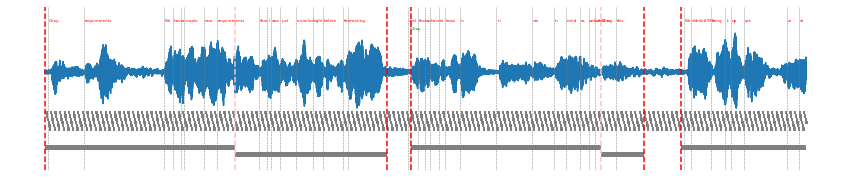

In [24]:
# 10 secs demo piece with s and x blocks
import numpy as np
import matplotlib.patches as patches

startTime = 1270.39
extractStartSample = int(startTime * 16000)
shortExtract = data[extractStartSample: extractStartSample + 10*16000, 4]
t = np.linspace(0, len(shortExtract)/16000, num=len(shortExtract))
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(t, shortExtract)
ax.set_ylim([-3000, 2000])
ax.axis('off')

xcoordsStart = []
xcoordsEnd = []
count = 0
for row in shortWordsExtract:
    xcoordsStart.append(row[0] - 1270.39)
    xcoordsEnd.append(row[1] - 1270.39)
    if row[3] == 'A':
        plt.text(row[0] - startTime + 0.01, 1550, row[2], fontsize=4, color="red")
    elif row[3] == 'B':
        plt.text(row[0] - startTime + 0.01, 1300, row[2], fontsize=4, color="green")
    elif row[3] == 'C':
        plt.text(row[0] - startTime + 0.01, 1600, row[2], fontsize=6, color="blue")
    elif row[3] == 'D':
        plt.text(row[0] - startTime + 0.01, 1700, row[2], fontsize=6, color="yellow")
    #count += 1
    #rect = patches.Rectangle((row[0] - 1270.39, -2500 - ((count - 1) % 2) * 100), row[1] - row[0], 160, linewidth=0, edgecolor='k', facecolor='gray', capstyle='round')
    #ax.add_patch(rect)
for xc in xcoordsStart:
    plt.axvline(x = xc, linewidth=0.5, color="gray", linestyle="dashed")
#for xc in xcoordsEnd:
    #plt.axvline(x = xc, color="pink", linestyle="dashed")

for num in range(10*100):
    #count += 1
    rect = patches.Rectangle((num * 0.01, - 1300 - (num % 6) * 100), 0.03, 100, linewidth=0, edgecolor='k', facecolor='gray', capstyle='round')
    ax.add_patch(rect)
    
count = 0
# Need to sort this out for more general extract start time
xcStart = [0, 2.5, 5.195-0.39, 5.195-0.39+2.5, 8.74-0.39]
xcEnd = [2.5, 4.49, 5.195-0.39+2.5, 5.195-0.39+3.07, 10]
for i in range(len(xcStart)):
    count += 1
    rect = patches.Rectangle((xcStart[i], -2400 - ((count - 1) % 2) * 200), xcEnd[i] - xcStart[i], 160, linewidth=0, edgecolor='k', facecolor='gray', capstyle='round')
    ax.add_patch(rect)
    
xcoords = [0, 4.49, 5.195-0.39, 5.195-0.39+3.07, 8.74-0.39]
for xc in xcoords:
    plt.axvline(x = xc, color="red", linestyle="dashed")
# Now adding in the split segments from DiarTk
xcoords2 = [2.5, 5.195-0.39+2.5]
for xc in xcoords2:
    plt.axvline(x = xc, color="pink", linestyle="dashed")
    
plt.show()

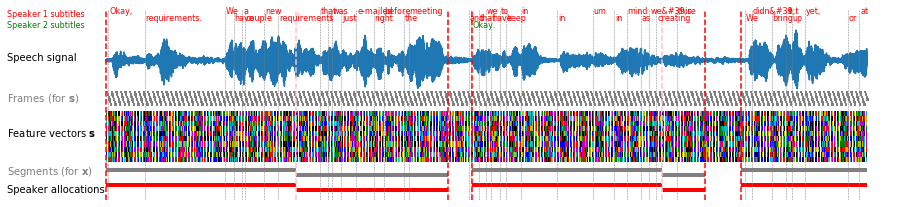

In [29]:
# 10 secs demo piece with s and x blocks
import matplotlib.patches as patches
import random

startTime = 1270.39
extractStartSample = int(startTime * 16000)
shortExtract = data[extractStartSample: extractStartSample + 10*16000, 4]
t = np.linspace(0, len(shortExtract)/16000, num=len(shortExtract))
fig, ax = plt.subplots(figsize=(15, 3.5))
ax.plot(t, shortExtract)
ax.set_ylim([-5500, 2000])
ax.axis('off')

xcoordsStart = []
xcoordsEnd = []
count = 0
for row in shortWordsExtract:
    xcoordsStart.append(row[0] - 1270.39)
    xcoordsEnd.append(row[1] - 1270.39)
    count += 1
    if row[3] == 'A':
        plt.text(row[0] - 1270.39 + 0.01, 1600 + (count % 2) * 250, row[2], fontsize=8, color="red")
    elif row[3] == 'B':
        plt.text(row[0] - 1270.39 + 0.01, 1300, row[2], fontsize=8, color="green")
    elif row[3] == 'C':
        plt.text(row[0] - 1270.39 + 0.01, 1900, row[2], fontsize=8, color="blue")
    elif row[3] == 'D':
        plt.text(row[0] - 1270.39 + 0.01, 2200, row[2], fontsize=8, color="yellow")
for xc in xcoordsStart:
    plt.axvline(x = xc, linewidth=0.5, color="gray", linestyle="dashed")

# s segments
for num in range(10*100):
    #count += 1
    rect = patches.Rectangle((num * 0.01, - 1300 - (num % 6) * 100), 0.03, 100, linewidth=0, edgecolor='k', facecolor='gray', capstyle='round')
    ax.add_patch(rect)
    # Feature vectors (actually s segments)
    for i in range(10):
        colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        n = random.randint(1, 7)
        rect = patches.Rectangle((num * 0.01, -2200 - 200*i), 0.008, 200, linewidth=0, edgecolor='k', facecolor=colours[n-1])
        ax.add_patch(rect)
    
count = 0
xcStart = [0, 2.5, 5.195-0.39, 5.195-0.39+2.5, 8.74-0.39]
xcEnd = [2.5, 4.49, 5.195-0.39+2.5, 5.195-0.39+3.07, 10]
# x segments
for i in range(len(xcStart)):
    count += 1
    # DiarTk separated
    rect = patches.Rectangle((xcStart[i], -4400 - ((count - 1) % 2) * 200), xcEnd[i] - xcStart[i], 160, linewidth=0, edgecolor='k', facecolor='gray', capstyle='round')
    ax.add_patch(rect)
    # Cluster allocated
    rect = patches.Rectangle((xcStart[i], -5000 - ((count - 1) % 2) * 200), xcEnd[i] - xcStart[i], 160, linewidth=0, edgecolor='r', facecolor='red', capstyle='round')
    ax.add_patch(rect)
    
    
xcoords = [0, 4.49, 5.195-0.39, 5.195-0.39+3.07, 8.74-0.39]
for xc in xcoords:
    plt.axvline(x = xc, color="red", linestyle="dashed")
# Now adding in the split segments from DiarTk
xcoords2 = [2.5, 5.195-0.39+2.5]
for xc in xcoords2:
    plt.axvline(x = xc, color="pink", linestyle="dashed")

plt.text(-1.3, 0, "Speech signal", fontsize=10, color="black")
plt.text(-1.3, 1750, "Speaker 1 subtitles", fontsize=8, color="red")
plt.text(-1.3, 1300, "Speaker 2 subtitles", fontsize=8, color="green")
plt.text(-1.3, -1600, "Frames (for " + r"$\bf{s}$" + ")", fontsize=10, color="gray")
plt.text(-1.3, -3000, "Feature vectors " + r"$\bf{s}$", fontsize=10, color="black")
plt.text(-1.3, -4500, "Segments (for " + r"$\bf{x}$" + ")", fontsize=10, color="gray")
plt.text(-1.3, -5200, "Speaker allocations", fontsize=10, color="black")
    
plt.show()

In [25]:
# Get oracle segments and DiarTk segments files
import OverlapFunctions

filenames = ["AMI_20050204-1206.scp", "results/AMI_20050204-1206.scp"]
segments = []
for filename in filenames:
    combinedSegments = OverlapFunctions.getSegs(filename)
    segments.append(OverlapFunctions.findCombinedSegs(combinedSegments))

In [26]:
segments[0][0]

[[127039, 127488],
 [127519, 127826],
 [127874, 128451],
 [128498, 128826],
 [128893, 129123],
 [129177, 129339],
 [129399, 129424],
 [129450, 129552],
 [129557, 129807],
 [129828, 129885],
 [129938, 130058],
 [130166, 130545],
 [130602, 130691],
 [130722, 130978],
 [130991, 131301],
 [131352, 131674],
 [131706, 131813],
 [131875, 132245],
 [132276, 132398],
 [132445, 132774],
 [132781, 133163],
 [133200, 133335],
 [133351, 133530],
 [133533, 133558],
 [133606, 134157],
 [134191, 134824],
 [134895, 134955],
 [135095, 135153],
 [135251, 135447],
 [135501, 135726],
 [135801, 135869],
 [136316, 136930],
 [136969, 137062],
 [137098, 137192],
 [137255, 137726],
 [137795, 137881],
 [137920, 137937],
 [137983, 138555],
 [138598, 138959],
 [138992, 139123],
 [139424, 139787],
 [139828, 140365],
 [140403, 140440],
 [140465, 140482],
 [140590, 140741],
 [140796, 140869],
 [141024, 141101],
 [141149, 141446],
 [141449, 141639],
 [141666, 141695],
 [141726, 141851],
 [141936, 142410],
 [142565, 14

In [27]:
segments[1][0]

[[127039, 127288],
 [127289, 127488],
 [127519, 127768],
 [127769, 127826],
 [127874, 128123],
 [128124, 128373],
 [128374, 128451],
 [128498, 128747],
 [128748, 128826],
 [128893, 129123],
 [129177, 129339],
 [129399, 129424],
 [129450, 129552],
 [129557, 129806],
 [129807, 129807],
 [129828, 129885],
 [129938, 130058],
 [130166, 130415],
 [130416, 130545],
 [130602, 130691],
 [130722, 130971],
 [130972, 130978],
 [130991, 131240],
 [131241, 131301],
 [131352, 131601],
 [131602, 131674],
 [131706, 131813],
 [131875, 132124],
 [132125, 132245],
 [132276, 132398],
 [132445, 132694],
 [132695, 132774],
 [132781, 133030],
 [133031, 133163],
 [133200, 133335],
 [133351, 133530],
 [133533, 133558],
 [133606, 133855],
 [133856, 134105],
 [134106, 134157],
 [134191, 134440],
 [134441, 134690],
 [134691, 134824],
 [134895, 134955],
 [135095, 135153],
 [135251, 135447],
 [135501, 135726],
 [135801, 135869],
 [136316, 136565],
 [136566, 136815],
 [136816, 136930],
 [136969, 137062],
 [137098, 13

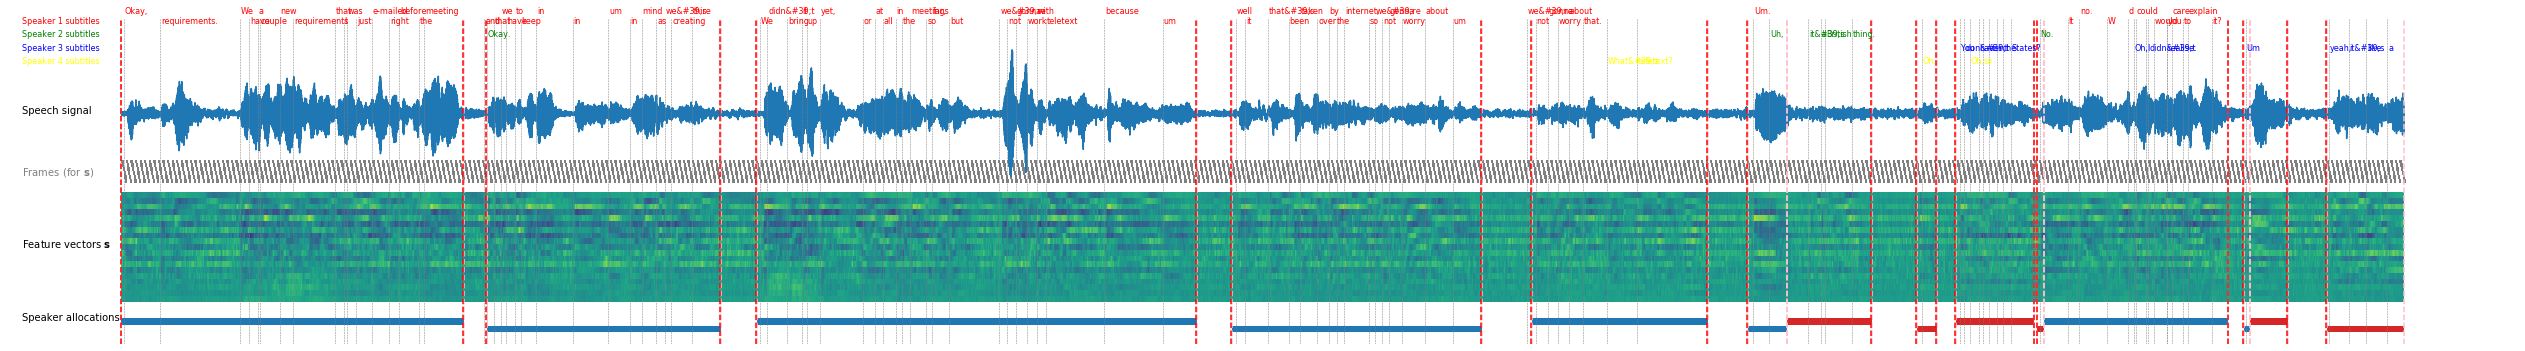

In [32]:
# 10 secs demo piece with s and x blocks
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm

startTime = 1270.39
secLen = 30
extractStartSample = int(startTime * 16000)
extractEndSample = int((startTime + secLen) * 16000)
shortExtract = data[extractStartSample: extractEndSample, 4]
t = np.linspace(0, len(shortExtract)/16000, num=len(shortExtract))
df = pd.DataFrame(result, columns=[i + 1 for i in range(len(result[0]))], index=[i + 1 for i in range(len(result))])

filename = "results/AMI_20050204-1206.rttm"
outputSegments = []
with open(filename, "r") as f:
    for line in f:
        lineItems = line.split(" ")
        outputSegments.append([float(lineItems[3]), round(float(lineItems[3]) + float(lineItems[4]), 2), int(lineItems[7][-1])])
dfSpeakers = pd.DataFrame(outputSegments, columns=["StartTime", "EndTime", "Speaker"])

fig, ax = plt.subplots(figsize=(45, 6))
#fig, ax = plt.subplots(figsize=(15, 3.5))
plt.plot(t, shortExtract)
ax.set_ylim([-6000, 2500])
ax.axis('off')

viridis = cm.get_cmap("viridis")
inferno = cm.get_cmap("inferno")

xcoordsStart = []
xcoordsEnd = []
speaker = []
count = 0
shortWordsExtract = []
for row in words:
    if row[0] >= startTime and row[0] <= (startTime + secLen):
        shortWordsExtract.append(row)

speakerColours = ["red", "green", "blue", "yellow"]
for row in shortWordsExtract:
    xcoordsStart.append(row[0] - startTime)
    xcoordsEnd.append(row[1] - startTime)
    speaker.append(row[2])
    count += 1
    if row[3] == 'A':
        ax.text(row[0] - startTime + 0.01, 2350 + (count % 2) * 250, row[2], fontsize=8, color=speakerColours[0])
    elif row[3] == 'B':
        ax.text(row[0] - startTime + 0.01, 2000, row[2], fontsize=8, color=speakerColours[1])
    elif row[3] == 'C':
        ax.text(row[0] - startTime + 0.01, 1650, row[2], fontsize=8, color=speakerColours[2])
    elif row[3] == 'D':
        ax.text(row[0] - startTime + 0.01, 1300, row[2], fontsize=8, color=speakerColours[3])
for xc in xcoordsStart:
    ax.axvline(x = xc, linewidth=0.5, color="gray", linestyle="dashed")

# s segments
maxMfcc = max(df.max(axis=0)) # For normalising color scale in heatmap
minMfcc = min(df.min(axis=0))
for num in range(secLen * 100):
    #count += 1
    rect = patches.Rectangle((num * 0.01, - 1300 - (num % 6) * 100), 0.03, 100, linewidth=0, edgecolor='k', facecolor='gray', capstyle='round')
    ax.add_patch(rect)
    # Feature vectors (actually s segments)
    for i in range(len(result[0])):
        col = (df.iloc[127039 + num][i + 1] - minMfcc)/(maxMfcc - minMfcc)
        #print(col)
        rect = patches.Rectangle((num * 0.01, -2200 - 150*i), 0.01, 150, linewidth=0, edgecolor='k', facecolor=viridis(col))
        ax.add_patch(rect)
    
count = 0
# Look at DiarTk segments first
xcStart = []
xcEnd = []
xcSpeakers = []
for n in range(len(dfSpeakers)):
#for row in dfSpeakers:
#for row in segments[1][0]:
    if dfSpeakers.iloc[n][0] >= startTime and dfSpeakers.iloc[n][0] <= (startTime + secLen):
        xcStart.append(dfSpeakers.iloc[n][0] - startTime)
        xcEnd.append(min(dfSpeakers.iloc[n][1] - startTime, secLen))
        xcSpeakers.append(dfSpeakers.iloc[n][2])
#xcStart = [0, 2.5, 5.195-0.39, 5.195-0.39+2.5, 8.74-0.39]
#xcEnd = [2.5, 4.49, 5.195-0.39+2.5, 5.195-0.39+3.07, 10]
# x segments
for i in range(len(xcStart)):
    count += 1
    # DiarTk separated
    #rect = patches.Rectangle((xcStart[i], -5200 - ((count - 1) % 2) * 200), xcEnd[i] - xcStart[i], 160, linewidth=0, edgecolor='k', facecolor='gray', capstyle='round')
    #ax.add_patch(rect)
    # Cluster allocated
    rect = patches.Rectangle((xcStart[i], -5500 - ((count - 1) % 2) * 200), xcEnd[i] - xcStart[i], 160, linewidth=0, edgecolor='r', facecolor="C"+str(int(xcSpeakers[i])), capstyle='round')
    ax.add_patch(rect)

# Vertical dashed lines from DiarTk segments
for xc in xcStart + xcEnd:
    ax.axvline(x = xc, color="pink", linestyle="dashed")
# Now adding in oracle segments which override DiarTk segments when overlapping
xcoords = []
for row in segments[0][0]:
    if row[0] >= int(startTime * 100) and row[0] <= int((startTime + secLen) * 100):
        xcoords.append(float((row[0] - 1) * 0.01 - startTime))
        if row[1] <= float((startTime + secLen) * 100):
            xcoords.append(float(row[1] * 0.01 - startTime))
for xc in xcoords:
    ax.axvline(x = xc, color="red", linestyle="dashed")

ax.text(-1.3, 0, "Speech signal", fontsize=10, color="black")
ax.text(-1.3, 2350, "Speaker 1 subtitles", fontsize=8, color="red")
ax.text(-1.3, 2000, "Speaker 2 subtitles", fontsize=8, color="green")
ax.text(-1.3, 1650, "Speaker 3 subtitles", fontsize=8, color="blue")
ax.text(-1.3, 1300, "Speaker 4 subtitles", fontsize=8, color="yellow")
ax.text(-1.3, -1600, "Frames (for " + r"$\bf{s}$" + ")", fontsize=10, color="gray")
ax.text(-1.3, -3500, "Feature vectors " + r"$\bf{s}$", fontsize=10, color="black")
#ax.text(-1.3, -5200, "Segments (for " + r"$\bf{x}$" + ")", fontsize=10, color="gray")
ax.text(-1.3, -5400, "Speaker allocations", fontsize=10, color="black")
    
plt.show()

## References <label id="references">

<div class="cite2c-biblio"></div>

<ol id="refsList">
    <li id="carletta"> &nbsp;&nbsp;J.Carletta, S. Ashby, S. Bourban, M. Flynn, T. Hain, J. Kadlec, V. Karaiskos, W. Kraaij, M. Kronenthal, G. Lathoud, M. Lincoln, A. Lisowska, and M. W. P. D. Reidsma, “The AMI meeting corpus: A pre-announcement,” in Proceedings of the Second International Workshop on Machine Learning for Multimodal Interaction (MLMI’05), 2006, pp. 28–39.</li>
    <li id="vijayasenan2012"> &nbsp;&nbsp;D. Vijayasenan and F. Valente, “DiarTk: An open source toolkit for research in multistream speaker diarization and its application to meetings recordings,” in Proc. Conf. of Intl. Speech Commun. Assoc. (INTERSPEECH), 2012, pp. 2170–2173.</li>
</ol>